In [2]:
from scipy.linalg import expm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie danych
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

bias_redX = test_data['GyroX'][:100].mean()
bias_redY = test_data['GyroY'][:100].mean()
bias_redZ = test_data['GyroZ'][:100].mean()

print(bias_redX, bias_redY, bias_redZ)

test_data['GyroX'] -= bias_redX
test_data['GyroY'] -= bias_redY
test_data['GyroZ'] -= bias_redZ*0.915

test_data.GyroX = test_data.GyroX / 1000
test_data.GyroY = test_data.GyroY / 1000
test_data.GyroZ = test_data.GyroZ / 1000

def calculate_skew_symmetric_matrix(gyro):
    """
    Tworzy macierz skośnie-symetryczną [omega]_x z prędkości kątowych żyroskopu.
    """
    wx, wy, wz = gyro
    return np.array([
        [0, -wz, wy],
        [wz, 0, -wx],
        [-wy, wx, 0]
    ])

def calculate_angles_from_rotation_matrix(R):
    """
    Wylicza kąty roll, pitch i yaw na podstawie macierzy rotacji R.
    """
    phi = np.arctan2(R[2, 1], R[2, 2])  # Roll
    theta = -np.arcsin(R[2, 0])         # Pitch
    psi = np.arctan2(R[1, 0], R[0, 0])  # Yaw
    return np.degrees(phi), np.degrees(theta), np.degrees(psi)

def integrate_gyro_with_rotation_matrix(data):
    """
    Całkowanie żyroskopu za pomocą macierzy rotacji i eksponencjalnej mapy.
    """
    n = len(data)
    roll_est = np.zeros(n)
    pitch_est = np.zeros(n)
    yaw_est = np.zeros(n)

    # Inicjalizacja macierzy rotacji
    R = np.eye(3)

    # Obliczanie czasu próbkowania
    dt = data['Time'].diff().fillna(0).to_numpy()

    for t in range(1, n):
        deg_to_rad = np.pi / 180
        gyro = np.array([
            data['GyroX'][t] * deg_to_rad,
            data['GyroY'][t] * deg_to_rad,
            data['GyroZ'][t] * deg_to_rad
        ])

        # Obliczanie macierzy skośnie-symetrycznej
        skew_symmetric = calculate_skew_symmetric_matrix(gyro)

        # Aktualizacja macierzy rotacji za pomocą eksponencjalnej mapy
        R_update = expm(skew_symmetric * dt[t])
        R = R @ R_update

        # Normalizacja macierzy rotacji (zapobieganie błędom numerycznym)
        U, _, Vt = np.linalg.svd(R)
        R = U @ Vt

        # Wyliczanie kątów z macierzy rotacji
        roll, pitch, yaw = calculate_angles_from_rotation_matrix(R)
        roll_est[t], pitch_est[t], yaw_est[t] = roll, pitch, yaw

    return roll_est, pitch_est, yaw_est

# Całkowanie z macierzą rotacji
test_roll, test_pitch, test_yaw = integrate_gyro_with_rotation_matrix(test_data)

# Dodanie wyników do danych testowych
test_data['roll_pred'] = test_roll
test_data['pitch_pred'] = test_pitch
test_data['yaw_pred'] = test_yaw

65.68678123 -576.217321 -243.45275499999997


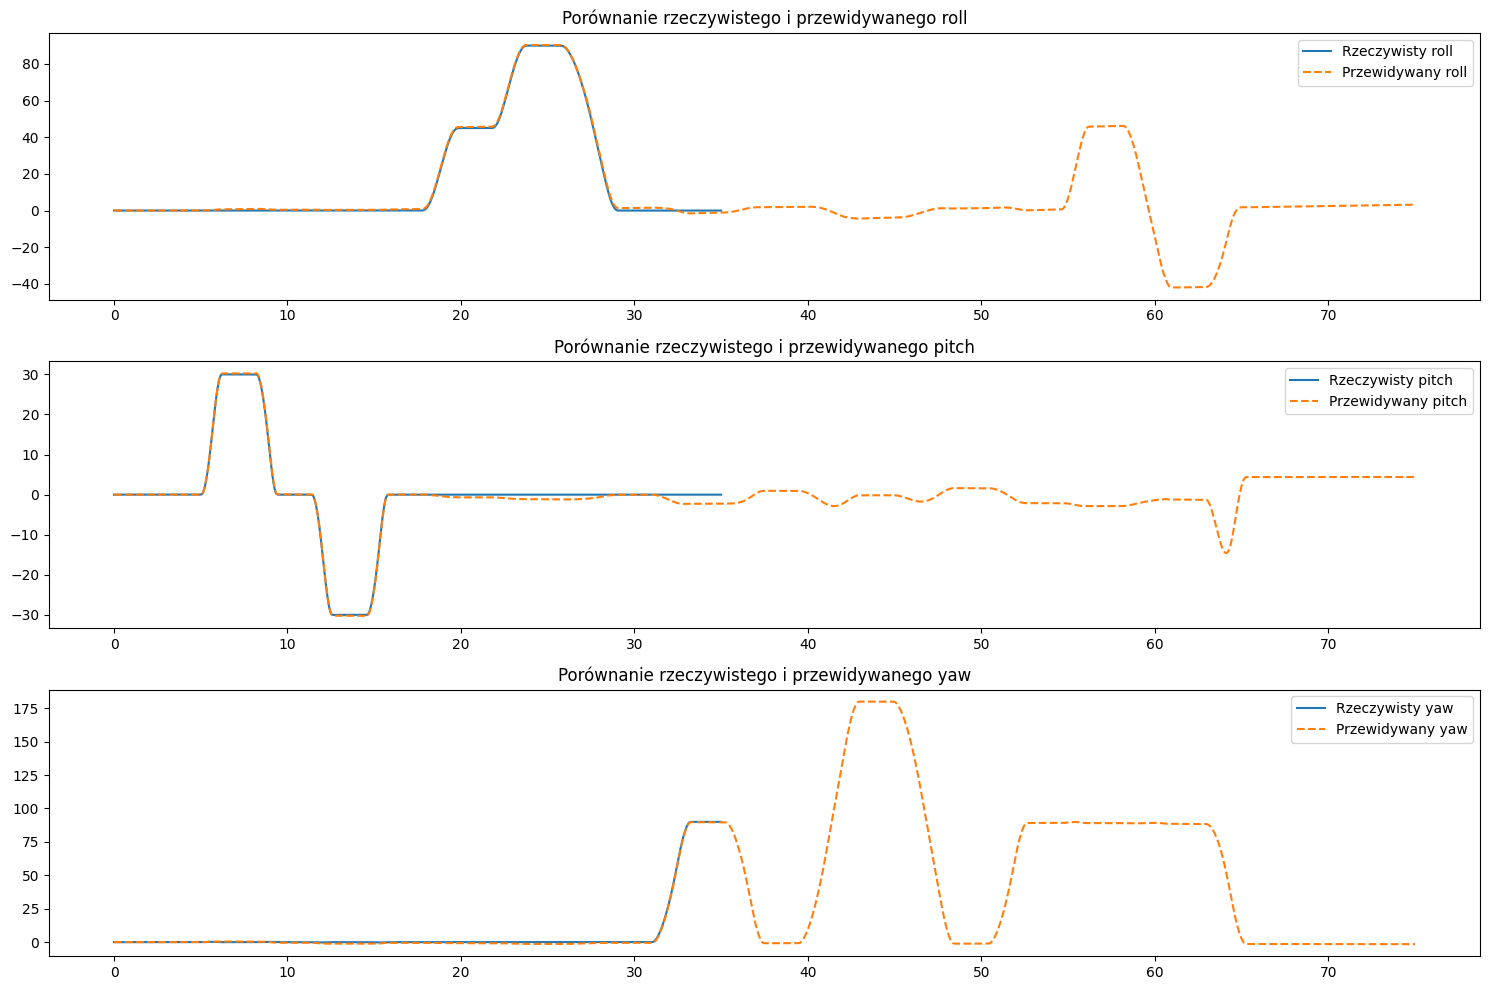

In [3]:
# Wizualizacja wyników
plt.figure(figsize=(15, 10))

# Roll
plt.subplot(3, 1, 1)
plt.plot(train_data['Time'], train_data['roll'], label='Rzeczywisty roll')
plt.plot(test_data['Time'], test_data['roll_pred'], label='Przewidywany roll', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego roll')

# Pitch
plt.subplot(3, 1, 2)
plt.plot(train_data['Time'], train_data['pitch'], label='Rzeczywisty pitch')
plt.plot(test_data['Time'], test_data['pitch_pred'], label='Przewidywany pitch', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego pitch')

# Yaw
plt.subplot(3, 1, 3)
plt.plot(train_data['Time'], train_data['yaw'], label='Rzeczywisty yaw')
plt.plot(test_data['Time'], test_data['yaw_pred'], label='Przewidywany yaw', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego yaw')

plt.tight_layout()
plt.show()